In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

data_key = 'ml-1m/'
# data_key = 'amz_Books/'
# data_key = 'amz_Movies_and_TV/'
# data_key = 'amz_Electronics/'
PROCESSED_DATA_ROOT = "/home/sl1471/workspace/experiments/"
target_path = PROCESSED_DATA_ROOT + data_key

### 1. Extract Results from Logs

In [2]:
from utils import extract_results
log_path = target_path + "logs/"
results = extract_results(log_path, ['lr', 'l2_coef', 'fair_group_feature', 'fair_lambda', 'fair_noise_sigma', 'n_local_step'], "f2rec_train_and_eval")
print(results.keys())

9it [00:00, 76.04it/s]

f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_gactivity.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_gGender.log
f2rec_train_and_eval_FedMF_lr0.01_reg0.1_losspairwisebpr_local1_fedavg.log
f2rec_train_and_eval_FedMF_lr0.003_reg0.1_losspairwisebpr_local3_fedavg.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda1.0_gGender.log
f2rec_train_and_eval_FedMF_lr0.001_reg0.1_losspairwisebpr_local1_fedavg.log


17it [00:00, 76.81it/s]

f2rec_train_and_eval_MF_lr0.00003_reg0.1_losspairwisebpr.log
f2rec_train_and_eval_MF_lr0.00001_reg0.1_losspairwisebpr.log


30it [00:00, 52.47it/s]

f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log
f2rec_train_and_eval_FedMF_lr0.0003_reg0.1_losspairwisebpr_local1_fedavg.log
f2rec_train_and_eval_FedMF_lr0.01_reg0.1_losspairwisebpr_local3_fedavg.log
f2rec_train_and_eval_FedMF_lr0.0003_reg0.1_losspairwisebpr_local5_fedavg.log
f2rec_train_and_eval_MF_lr0.00001_reg1.0_losspairwisebpr.log
f2rec_train_and_eval_MF_lr0.00003_reg0_losspairwisebpr.log


45it [00:01, 36.06it/s]

f2rec_train_and_eval_FedMF_lr0.003_reg0.1_losspairwisebpr_local1_fedavg.log
f2rec_train_and_eval_MF_lr0.0001_reg1.0_losspairwisebpr.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.3_gactivity.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_gactivity.log
f2rec_train_and_eval_FedMF_lr0.001_reg0.1_losspairwisebpr_local3_fedavg.log


50it [00:01, 32.09it/s]

f2rec_train_and_eval_MF_lr0.0001_reg0_losspairwisebpr.log
f2rec_train_and_eval_MF_lr0.00001_reg0_losspairwisebpr.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_gAge.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_gAge.log
f2rec_train_and_eval_FedMF_lr0.0001_reg0.1_losspairwisebpr_local1_fedavg.log


56it [00:01, 34.60it/s]

f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0_gGender.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_gactivity.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda1.0_gactivity.log
f2rec_train_and_eval_FedMF_lr0.0001_reg0.1_losspairwisebpr_local5_fedavg.log


72it [00:01, 43.94it/s]

f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0_gactivity.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.7_gactivity.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0_gAge.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_gGender.log
f2rec_train_and_eval_MF_lr0.00003_reg1.0_losspairwisebpr.log
dict_keys([1, 8, 15, 16, 19, 21, 23, 29, 30, 31, 32, 34, 38, 39, 41, 44, 45, 46, 47, 49, 51, 55, 56, 57, 59, 66, 69, 70, 71])


In [3]:
import json
print("Example:")
print(json.dumps(list(results.values())[0], indent = 4))

Example:
{
    "args": "cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda0.5_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.vocab', n_neg=1, n_neg_val=100, n_neg_test=-1, n_round=1, optimizer='Adam', epoch=30, check_epoch=1, lr=3e-05, ba

In [4]:
import numpy as np
metrics = []
for m_name in ['HR', 'RECALL', 'P', 'F1', 'NDCG']:
    metrics += [f"{m_name}@{i}" for i in [1,5,10,20,50]]
metrics += ["AUC", "MR", "MRR"]
for m_name in metrics:
    for k, res_dict in results.items():
        if m_name in res_dict:
            res_dict[m_name] = np.mean(res_dict[m_name])

In [5]:
import pandas as pd
df = pd.DataFrame.from_dict(results, orient = 'index')

In [6]:
import os
import datetime
try:
    os.mkdir(target_path + "results/")
except:
    print("Dir exists: '" + target_path + "results/'")
result_file_path = target_path + "results/" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".csv"
df.to_csv(result_file_path, sep = '\t')

Dir exists: '/home/sl1471/workspace/experiments/ml-1m/results/'


## Plots

### Lambda

In [9]:
df

,args,model_name,lr,l2_coef,fair_group_feature,fair_lambda,fair_noise_sigma,n_local_step,HR@1,P@1,...,F1@20,NDCG@20,HR@50,P@50,RECALL@50,F1@50,NDCG@50,MR,MRR,AUC
1,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,0.5,NaN,NaN,0.068582,0.068582,...,0.046166,0.071368,0.632846,0.039851,0.155009,0.052453,0.094718,76.159751,0.021771,0.826675
8,"cuda=1, seed=19, train=False, train_and_eval=T...",FedMF,0.00300,0.1,NaN,NaN,NaN,3,0.066423,0.066423,...,0.043330,0.067499,0.598306,0.037018,0.141261,0.048423,0.088329,101.560559,0.020070,0.766201
15,"cuda=2, seed=19, train=False, train_and_eval=T...",MF,0.00003,0.1,Gender,1.0,NaN,NaN,0.070907,0.070907,...,0.047562,0.075499,0.637662,0.040136,0.160273,0.053017,0.098994,78.587273,0.023570,0.819796
16,"cuda=2, seed=19, train=False, train_and_eval=T...",FedMF,0.00100,0.1,NaN,NaN,NaN,1,0.064430,0.064430,...,0.043431,0.066723,0.597310,0.036881,0.140313,0.048246,0.087327,103.807928,0.019719,0.761074
19,"cuda=3, seed=19, train=False, train_and_eval=T...",MF,0.00003,0.1,NaN,NaN,NaN,NaN,0.066838,0.066838,...,0.040208,0.063383,0.613417,0.038331,0.146105,0.050242,0.088579,88.060760,0.020043,0.810460
21,"cuda=3, seed=19, train=False, train_and_eval=T...",MF,0.00001,0.1,NaN,NaN,NaN,NaN,0.048572,0.048572,...,0.036301,0.055018,0.581368,0.034000,0.120554,0.043783,0.074811,105.109896,0.016306,0.779343
23,"cuda=3, seed=19, train=False, train_and_eval=T...",MF,0.00010,0.1,NaN,NaN,NaN,NaN,0.072816,0.072816,...,0.044626,0.070860,0.613168,0.038060,0.148177,0.050241,0.093307,85.632481,0.022509,0.813692
29,"cuda=2, seed=19, train=False, train_and_eval=T...",FedMF,0.00030,0.1,NaN,NaN,NaN,1,0.056460,0.056460,...,0.042102,0.063283,0.597144,0.036390,0.138362,0.047650,0.084244,111.311681,0.018173,0.745807
30,"cuda=1, seed=19, train=False, train_and_eval=T...",FedMF,0.01000,0.1,NaN,NaN,NaN,3,0.058784,0.058784,...,0.043660,0.066233,0.599469,0.036778,0.141029,0.048138,0.086796,101.439389,0.019163,0.766446
31,"cuda=1, seed=19, train=False, train_and_eval=T...",FedMF,0.00030,0.1,NaN,NaN,NaN,5,0.067586,0.067586,...,0.042064,0.065302,0.599801,0.036921,0.141175,0.048308,0.087170,102.570915,0.019655,0.763850


In [12]:
sub_df = df[df['model_name']=='MF']
sub_df = sub_df[sub_df['fair_group_feature']=='activity']
sub_df = sub_df[df['l2_coef']==0.1]
sub_df

/home/sl1471/anaconda3/envs/edgecdr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,args,model_name,lr,l2_coef,fair_group_feature,fair_lambda,fair_noise_sigma,n_local_step,HR@1,P@1,...,F1@20,NDCG@20,HR@50,P@50,RECALL@50,F1@50,NDCG@50,MR,MRR,AUC
1,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,0.5,NaN,NaN,0.068582,0.068582,...,0.046166,0.071368,0.632846,0.039851,0.155009,0.052453,0.094718,76.159751,0.021771,0.826675
41,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,0.3,NaN,NaN,0.073065,0.073065,...,0.046049,0.071955,0.631020,0.039628,0.154345,0.052132,0.095170,76.568376,0.022294,0.825078
44,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,0.1,NaN,NaN,0.075888,0.075888,...,0.046232,0.072910,0.632680,0.039628,0.153447,0.052088,0.095697,77.132306,0.022828,0.823499
56,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,-0.1,NaN,NaN,0.075556,0.075556,...,0.046070,0.072908,0.635005,0.039303,0.152160,0.051747,0.095368,77.756452,0.022846,0.821496
57,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,1.0,NaN,NaN,0.058452,0.058452,...,0.043155,0.065792,0.622551,0.038811,0.145112,0.050664,0.088547,84.239693,0.019396,0.811036
66,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,0.0,NaN,NaN,0.075556,0.075556,...,0.046104,0.072716,0.634009,0.039469,0.152966,0.051890,0.095448,77.485304,0.022833,0.822568


In [24]:
import matplotlib.pyplot as plt
import numpy as np
def plot_recommendation_over_lambda(df, metrics, ncol = 3):
    '''
    @input:
    - stats: {field_name: {key: [values]}}
    - features: [field_name]
    - ncol: number of subplots in each row
    '''
    assert ncol > 0
    N = len(metrics)
    X,indices = np.array(df['fair_lambda']),np.argsort(df['fair_lambda'])
    plt.figure(figsize = (16, 4*((N-1)//ncol+1)))
    for i,field in enumerate(metrics):
        plt.subplot((N-1)//ncol+1,ncol,i+1)
        Y = np.array(df[field])
        Y = [Y[i] for i in indices]
        plt.plot(X,Y)
        plt.title(field)
        scale = 1e-7 + np.max(Y) - np.min(Y)
        plt.ylim(np.min(Y) - scale * 0.05, np.max(Y) + scale * 0.05)
    plt.show()

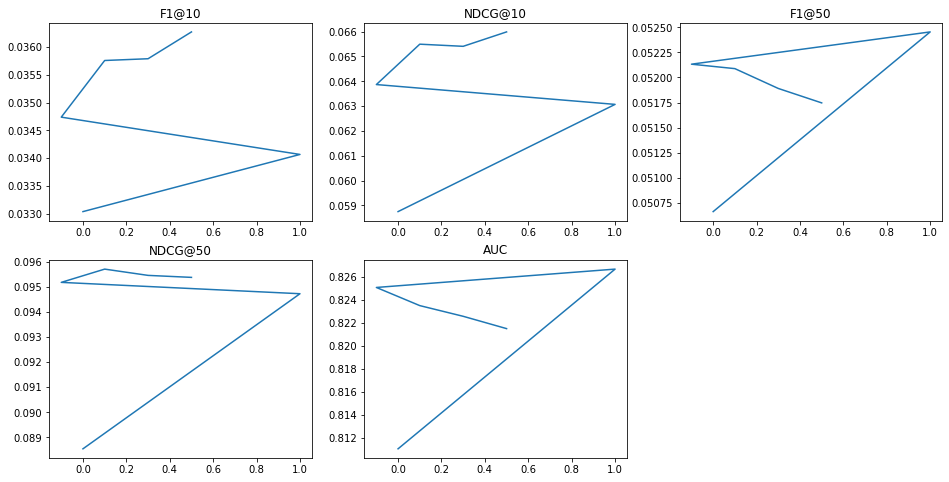

In [25]:
plot_recommendation_over_lambda(sub_df, ['F1@10', 'NDCG@10', 'F1@50', 'NDCG@50', 'AUC'], ncol = 3)